In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

ras = [10000, 100000, 1000000]
splits = ["val", "test", "train"]


def check(check):
    for split in splits:
        for ra in ras:
            path = f"../data/datasets/2D/{split}/ra{ra}.h5"
            with h5py.File(path, "r") as file:
                check(file, path)

# Dataset Info

In [ ]:
def dataset_info(file, path):
    print(
        f"file {path} has {file.attrs['episodes']} episodes with dt {file.attrs['dt']}s"
    )


check(dataset_info)

file ../data/datasets/2D/val/ra10000.h5 has 10 episodes
file ../data/datasets/2D/val/ra100000.h5 has 10 episodes
file ../data/datasets/2D/val/ra1000000.h5 has 10 episodes
file ../data/datasets/2D/test/ra10000.h5 has 20 episodes
file ../data/datasets/2D/test/ra100000.h5 has 20 episodes
file ../data/datasets/2D/test/ra1000000.h5 has 20 episodes
file ../data/datasets/2D/train/ra10000.h5 has 50 episodes
file ../data/datasets/2D/train/ra100000.h5 has 50 episodes
file ../data/datasets/2D/train/ra1000000.h5 has 50 episodes


# Validate Temperature

In [80]:
def validate(file, path):
    passed = True
    episodes = file.attrs["episodes"]
    steps = file.attrs["steps"]

    for episode in range(episodes):
        states = file[f"states{episode}"]
        assert len(states) == steps, (
            f"Mismatch in number of steps for episode {episode}: expected {steps}, got {len(states)}"
        )

        for step in range(steps):
            assert states[step].shape == (5, 64, 96), (
                f"Unexpected shape at episode {episode}, step {step}: {states[step].shape}"
            )
            # validate temperature
            min, max = states[step][0].min(), states[step][0].max()
            if min < 1 or max > 2:
                print(
                    f"in file {path} at episode {episode} and step {step} - Temperature: min={min}, max={max}"
                )
                passed = False
    if not passed:
        print(f"File {path} failed validation.")
    else:
        print(
            f"File {path} passed validation with {episodes} episodes and {steps} steps each."
        )


check(validate)

File ../data/datasets/2D/val/ra10000.h5 passed validation with 10 episodes and 1000 steps each.
File ../data/datasets/2D/val/ra100000.h5 passed validation with 10 episodes and 1000 steps each.
File ../data/datasets/2D/val/ra1000000.h5 passed validation with 10 episodes and 1000 steps each.
File ../data/datasets/2D/test/ra10000.h5 passed validation with 20 episodes and 1000 steps each.
File ../data/datasets/2D/test/ra100000.h5 passed validation with 20 episodes and 1000 steps each.
File ../data/datasets/2D/test/ra1000000.h5 passed validation with 20 episodes and 1000 steps each.
File ../data/datasets/2D/train/ra10000.h5 passed validation with 50 episodes and 1000 steps each.
File ../data/datasets/2D/train/ra100000.h5 passed validation with 50 episodes and 1000 steps each.
in file ../data/datasets/2D/train/ra1000000.h5 at episode 26 and step 25 - Temperature: min=1.0038559436798096, max=2.000696897506714
in file ../data/datasets/2D/train/ra1000000.h5 at episode 30 and step 24 - Temperatu

# Mean, Min and Max per channel

Calculating mean, min, max for split val


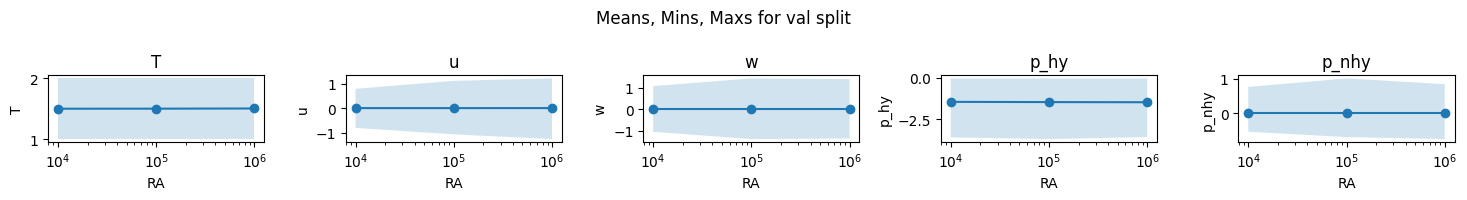

Calculating mean, min, max for split test


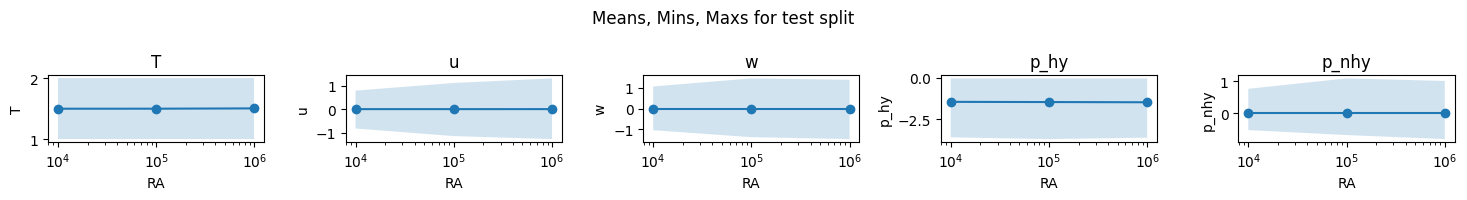

Calculating mean, min, max for split train


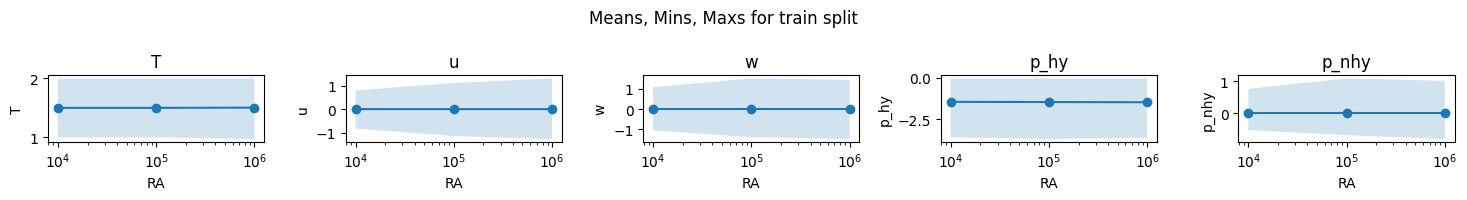

In [81]:
def mmm(file, path):
    episodes = file.attrs["episodes"]

    channels = ["T", "u", "w", "p_hy", "p_nhy"]
    means, mins, maxs = {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []

    for episode in range(episodes):
        # print mean, min, max per channel
        states = np.array(file[f"states{episode}"])

        for ch, name in enumerate(channels):
            means[name].append(states[:, ch, :, :].mean())
            mins[name].append(states[:, ch, :, :].min())
            maxs[name].append(states[:, ch, :, :].max())

    means = {k: np.mean(v) for k, v in means.items()}
    mins = {k: np.min(v) for k, v in mins.items()}
    maxs = {k: np.max(v) for k, v in maxs.items()}
    return means, mins, maxs


for split in splits:
    print(f"Calculating mean, min, max for split {split}")
    channels = ["T", "u", "w", "p_hy", "p_nhy"]
    means, mins, maxs = {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []

    for ra in ras:
        path = f"../data/datasets/2D/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            mean, min, max = mmm(file, path)
            for name in channels:
                means[name].append(mean[name])
                mins[name].append(min[name])
                maxs[name].append(max[name])

    # plot means, mins, maxs
    fig, axs = plt.subplots(1, 5, figsize=(15, 2))
    fig.suptitle(f"Means, Mins, Maxs for {split} split")
    for i, name in enumerate(channels):
        axs[i].plot(ras, means[name], label="Mean", marker="o")
        axs[i].fill_between(
            ras, mins[name], maxs[name], alpha=0.2, label="Min-Max Range"
        )
        axs[i].set_title(name)
        axs[i].set_xlabel("RA")
        axs[i].set_ylabel(name)
        axs[i].set_xscale("log")
    plt.tight_layout()
    plt.show()

# Nusselt Number

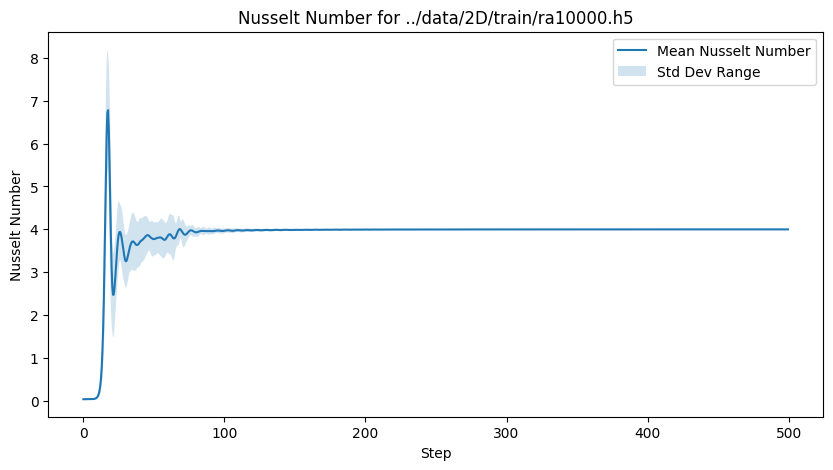

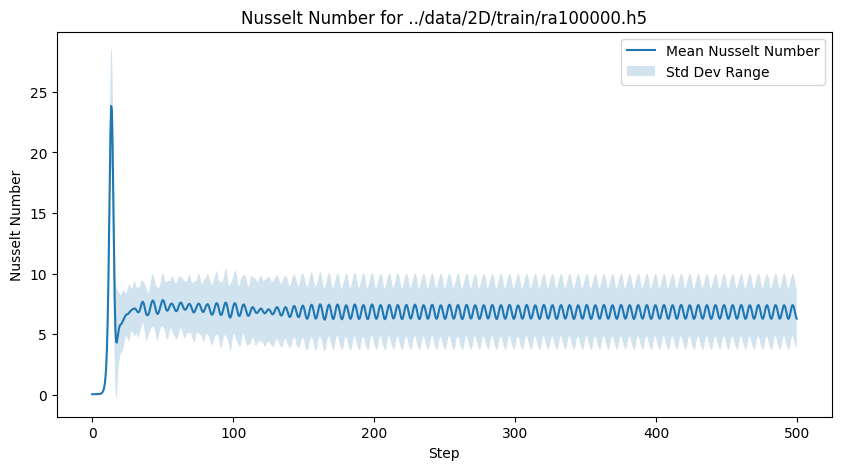

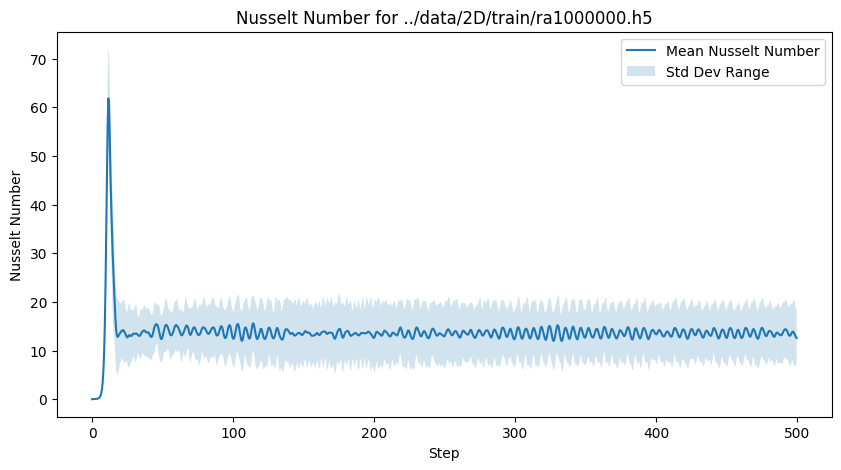

In [3]:
def nu(file, path):
    episodes = file.attrs["episodes"]
    dt = file.attrs["dt"]
    steps = file.attrs["steps"]
    time = np.arange(0, steps * dt, dt)

    nus = []
    for episode in range(episodes):
        # print mean, min, max per channel
        nus.append(np.array(file[f"nusselts{episode}"]))
    nus = np.array(nus)
    mean_nu = nus.mean(axis=0)
    std_nu = nus.std(axis=0)

    # plot musselt to step
    plt.figure(figsize=(10, 5))
    plt.plot(time, mean_nu, label="Mean Nusselt Number")
    plt.fill_between(
        time, mean_nu - std_nu, mean_nu + std_nu, alpha=0.2, label="Std Dev Range"
    )
    plt.legend()
    plt.title(f"Nusselt Number for {path}")
    plt.xlabel("Step")
    plt.ylabel("Nusselt Number")
    plt.show()


for ra in ras:
    path = f"../data/2D/train/ra{ra}.h5"
    with h5py.File(path, "r") as file:
        nu(file, path)

# Divergence

In [ ]:
import torch
from torch.nn.functional import mse_loss


def compute_div(state):
    # state in [C, H, W]
    u = state[1]
    w = state[2]

    # grid spacings
    Lx, Lz = (2 * np.pi, 2.0)
    nz, nx = u.shape
    dx = Lx / nx
    dz = Lz / nz

    # centered finite differences everywhere
    dudx = torch.gradient(u, dim=1, spacing=dx)[0]
    dwdz = torch.gradient(w, dim=0, spacing=dz)[0]
    div = dudx + dwdz

    return div, dudx, dwdz

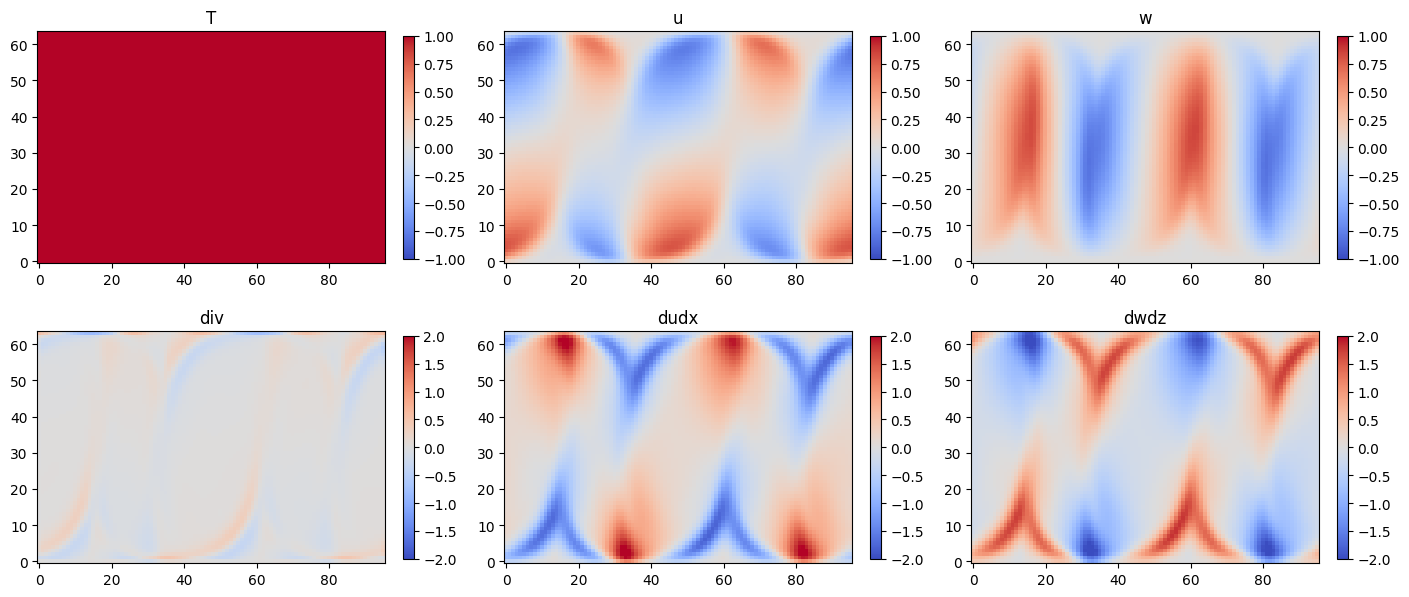

In [13]:
path = "../data/2D/train/ra100000.h5"
with h5py.File(path, "r") as file:
    steps = file.attrs["steps"]
    state = file["states3"][100]
    state = torch.from_numpy(state)

T = state[0]
u = state[1]
w = state[2]
div, dudx, dwdz = compute_div(state)

# visualize fields and derivatives
top_fields = [("T", T), ("u", u), ("w", w)]
bottom_fields = [("div", div), ("dudx", dudx), ("dwdz", dwdz)]

fig, axes = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True)
for col, (name, field) in enumerate(top_fields):
    ax = axes[0, col]
    img = ax.imshow(
        field.cpu().detach().numpy(),
        cmap="coolwarm",
        origin="lower",
        vmin=-1,
        vmax=1,
    )
    ax.set_title(name)
    fig.colorbar(img, ax=ax, shrink=0.8)

for col, (name, field) in enumerate(bottom_fields):
    ax = axes[1, col]
    if field is None:
        ax.axis("off")
        continue
    img = ax.imshow(
        field.cpu().detach().numpy(),
        cmap="coolwarm",
        origin="lower",
        vmin=-2,
        vmax=2,
    )
    ax.set_title(name)
    fig.colorbar(img, ax=ax, shrink=0.8)

plt.show()

In [ ]:
for ra in ras:
    path = f"../data/2D/train/ra{ra}.h5"
    with h5py.File(path, "r") as file:
        steps = file.attrs["steps"]
        episodes = file.attrs["episodes"]

        list = []
        list1 = []
        for episode in range(episodes):
            states = file[f"states{episode}"]
            for step in range(steps):
                state = torch.from_numpy(states[step])
                div, _, _ = compute_div(state)
                list.append(mse_loss(div, torch.zeros_like(div)))
                list1.append(torch.sqrt(torch.mean(div**2)))

    print(f"Mean divergence loss for Ra = {ra}: {torch.mean(torch.tensor(list)):.6f}")
    print(f"Mean RMS divergence for Ra = {ra}: {torch.mean(torch.tensor(list1)):.6f}")
    print("--------------------------------------------------------")

Mean divergence loss for Ra = 10000: 0.004477
Mean RMS divergence for Ra = 10000: 0.065975
Mean divergence loss for Ra = 100000: 0.009526
Mean RMS divergence for Ra = 100000: 0.094730
Mean divergence loss for Ra = 1000000: 0.027245
Mean RMS divergence for Ra = 1000000: 0.161617
